In [1]:
# Import libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pandas as pd
from IPython.display import display
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [2]:
#################### Initialize all functions ####################

sigmoid = lambda p: (((p * 20 - 10) / np.sqrt(10 + (p * 20 - 10)**2)) + 1) / 2


# Defining SIR model differential equations
def deriv1(y, t, days, l_on, l_off, steps, wd):
    p, s, w = y

    light = calcLight(days, l_on, l_off, steps, t)

    dp = sum([
        # Influence of nutrients in the soil on potato growth
        (1. * s**1.5) * (1 * p),
        # Influence of light on potato growth
        +(1.5 * p) * light,
        # Competition with themselves
        -(0.85 * sigmoid(p)),
        # Potato loss due to worms
        -(2 * w) * (1. * p)
    ])
    ds = sum([
        # Soil nutrient consumption from potatoes
        (-1. * p**1.5) * (1 * s),
        # Worm contribution by feces to soil nutrients
        +(0.3 * w)
    ])
    dw = sum([
        # Toxic effect of too much nutrients on worm population
        (-2 * s) * (1 * w),
        # Migration caused by potatoes
        +(1.2 * p),
        # Worm birth
        +(0.1 * w),
        # Worm death
        -(wd * w)
    ])

    return dp, ds, dw


def calcLight(days, l_on, l_off, steps, t):
    l_steps = np.linspace(l_off, l_on, steps)
    t_steps = np.linspace(0, 1, steps + 1)
    light = 0

    if steps != 99:
        for i in range(len(l_steps)):
            if days * t_steps[i] <= t <= days * t_steps[i + 1]:
                light = l_steps[i]
    else:
        if days * 0.25 <= t <= days * 0.75:
            light = l_on
        else:
            light = l_off
    return light


def procData(data, title):
    df = pd.DataFrame({
        "Potatoes": data[:, 0],
        "Nutrients": data[:, 1],
        "Worms": data[:, 2]
    })
    dfd = df.describe().drop(["25%", "50%", "75%", "count"])
    missings = df.isnull().sum() / 50 * 100
    dfd = dfd.append(pd.DataFrame({"Missing (%)": missings}).T)
    dfd["Greenhouse"] = title[-1]
    dfd["Statistics"] = dfd.index
    return dfd


def plotplot(ax,
             title,
             data,
             days,
             lights,
             pturb=False,
             pmean=1,
             pstd=0.2,
             prem=9. / 10,
             measurements=10):

    # Add noise and missing numbers
    if pturb:
        perturb = np.random.normal(pmean, pstd, data.shape)
        data *= perturb
        masks = np.random.choice([np.nan, 1],
                                 size=(data.shape),
                                 p=[prem, 1 - prem])
        data *= masks * 10

    descr = procData(data, title)

    P, S, W = data[:, 0], data[:, 1], data[:, 2]
    t = np.linspace(1, days, days * measurements)

    # # Plot
    ax.plot(t, P, 'ob', alpha=0.8, markersize=2.5, label='Potatoes')
    ax.plot(t, S, 'or', alpha=0.8, markersize=2.5, label='Nutrients')
    ax.plot(t, W, 'og', alpha=0.8, markersize=2.5, label='Worms')

    # Prettyfie that graph
    title = title + f" (L={np.mean(lights)})" 
    ax.set_xlabel('Time')
    ax.set_title(title)
    #     ax.set_ylim((0, 2))
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Set axis ranges; by default this will put major ticks every 25.
    ax.set_xlim(0, max(t))
    tmp = np.dstack((P,S,W)).flatten()
    ax.set_ylim(0, max(tmp[~np.isnan(tmp)])*1.1)

    # Change major ticks to show every 10.
    ax.xaxis.set_major_locator(MultipleLocator(10))
#     ax.yaxis.set_major_locator(MultipleLocator(4))

    # Change minor ticks to show every 5. (10/2 = 5)
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
#     ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Turn grid on for both major and minor ticks and style minor slightly
    # differently.
    ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.8)
    ax.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    return descr


def interestPlots(interest,
                  sx=6,
                  sy=4,
                  x=2,
                  pturb=False,
                  pmean=1,
                  pstd=0.2,
                  prem=9. / 10,
                  measurements=10):
    n = len(interest)
    fig, axes = plt.subplots(nrows=int(np.ceil(n / x)),
                             ncols=x,
                             figsize=(sx * x, sy * int(np.ceil(n / x))),
                             sharey=False,
                             sharex=False)
    descriptives = []
    for wI in range(len(interest)):
        days, l_on, l_off, steps, y0, wd = interest[wI]

        t = np.linspace(1, days, days * measurements)
        lights = [calcLight(days, l_on, l_off, steps, i) for i in t]
        data = odeint(deriv1, y0, t, args=(days, l_on, l_off, steps, wd))

        if steps != 99: st = steps
        else: st = 'off/on/off'

        #         title = f"Time units: {days}, Lights highest: {l_on}" + \
        #               f" Lights lowest: {l_off}\nSteps: {st}, Worm death: {wd}"
        title = f"Greenhouse {wI+1}"

        if np.ceil(n / x) < 2: axs = axes[wI % x]
        else: axs = axes[int(np.floor(wI / x)), wI % x]

        descriptives.append(
            plotplot(axs,
                     title,
                     data,
                     days,
                     lights,
                     pturb=pturb,
                     pmean=pmean,
                     pstd=pstd,
                     prem=prem,
                     measurements=measurements))
    plt.tight_layout()
    plt.savefig("4farmers.png")
    plt.show()

    df = pd.melt(pd.concat(descriptives),
                 id_vars=['Greenhouse', 'Statistics'],
                 value_vars=['Potatoes', 'Nutrients', 'Worms'],
                 value_name='Values')
    lights = pd.DataFrame({
        "Greenhouse": np.linspace(1,4,4).astype(int).astype(str),
        "Statistics": ["" for _ in descriptives],
        "variable": ["Lights" for _ in descriptives],
        "Values": np.linspace(1.25, 2, len(descriptives))
    })
    df = pd.concat([lights,df], ignore_index=True)

    stats = df.set_index(['Greenhouse','variable','Statistics']).unstack('Greenhouse').round(2)
    display(stats)

    dscr = pd.concat(descriptives).set_index(["Greenhouse", "Statistics"]).round(2)
    display(dscr)

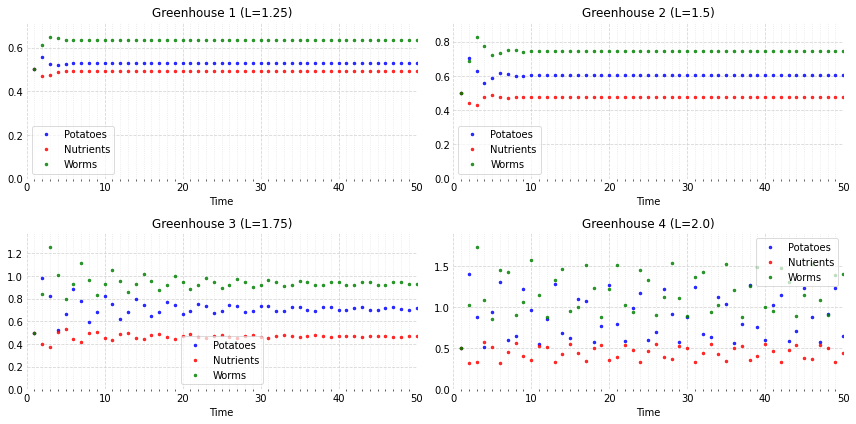

Values                  
Greenhouse                 1     2     3     4
variable  Statistics                          
Lights                  1.25  1.50  1.75  2.00
Nutrients Missing (%)   0.00  0.00  0.00  0.00
          max           0.50  0.50  0.53  0.57
          mean          0.49  0.48  0.47  0.45
          min           0.47  0.43  0.37  0.32
          std           0.00  0.01  0.03  0.08
Potatoes  Missing (%)   0.00  0.00  0.00  0.00
          max           0.56  0.70  0.98  1.41
          mean          0.53  0.60  0.71  0.88
          min           0.50  0.50  0.50  0.50
          std           0.01  0.02  0.07  0.27
Worms     Missing (%)   0.00  0.00  0.00  0.00
          max           0.65  0.83  1.25  1.73
          mean          0.63  0.74  0.93  1.19
          min           0.50  0.50  0.50  0.50
          std           0.02  0.04  0.09  0.26

Potatoes  Nutrients  Worms
Greenhouse Statistics                             
1          mean             0.53       0.49   0.63
           std              0.01       0.00   0.02
           min              0.50       0.47   0.50
           max              0.56       0.50   0.65
           Missing (%)      0.00       0.00   0.00
2          mean             0.60       0.48   0.74
           std              0.02       0.01   0.04
           min              0.50       0.43   0.50
           max              0.70       0.50   0.83
           Missing (%)      0.00       0.00   0.00
3          mean             0.71       0.47   0.93
           std              0.07       0.03   0.09
           min              0.50       0.37   0.50
           max              0.98       0.53   1.25
           Missing (%)      0.00       0.00   0.00
4          mean             0.88       0.45   1.19
           std              0.27       0.08   0.26
           min              0.50       0.32   0.50
           max              1.41       0.57   1.73
           Missing (%)      0.00       0.00   0.00

In [6]:
np.random.seed(89)
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w), worm death
#     [50, 0, 0, 1, (0.5, 0.5, 0.5), 0.1],
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 0.115],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 0.12],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 0.08],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 0.11],
]
interestPlots(interest,
              sx=6,
              sy=3,
              x=2,
              pturb=False,
              pmean=1,
              pstd=0.1,
              prem=6 / 10,
              measurements=1)

In [569]:
np.linspace(1,50,50)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [ ]:
from tqdm import tqdm
def metropol(y0, df, days, l_val_off, N):
    startp = [0.5, 0.5]
    tdata = odeint(df, y0, t, args=(startp[0], days, l_val_off, startp[1]))
    p = mean_absolute_error(data, tdata)

    score = [p]
    bestp = [startp]

    for i in tqdm(range(N)):
        rn = bestp[-1] + np.random.normal(0, .15, 2)
        tdata = odeint(df, y0, t, args=(startp[0], days, l_val_off, startp[1]))
        p = mean_absolute_error(data, tdata)
        if p <= score[-1]:
            score.append(p)
            bestp.append(rn)
        else:
            u = np.random.rand()
            if u < score[-1] / p:
                score.append(p)
                bestp.append(list(rn))
    return score, np.array(bestp)

def hist_plot(array):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,)
    ax.hist(array, bins=1000)    
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')


N = 10000
d = metropol(y0, deriv1, days, l_val_off, N)

In [ ]:
hist_plot(d[1][:, 0])
hist_plot(d[1][:, 1])

In [ ]:
# l_val_on = 0.3
l_val_off = 1
alpha = .5
fs = [deriv1, deriv2, deriv3]
for df in fs:
    score = 100000
    bestp = (100, 100)
    for j in range(11):
        for i in range(11):
            tdata = odeint(df, y0, t, args=(i/10, days, l_val_off, j/10))
            mae = mean_absolute_error(data, tdata)
            if mae < score: 
                score = mae
                bestp = (j/10, i/10)
                print(bestp, mae)
                
    tdata = odeint(df, y0, t, args=(bestp[1], days, l_val_off, bestp[0]))
    X, Y, Z = tdata[:, 0], tdata[:, 1], tdata[:, 2]

    # Plot the data on four separate curves
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)

    # # Plot
    ax.plot(t, X, 'b', alpha=0.5, lw=2, label='X')
    ax.plot(t, Y, 'r', alpha=0.5, lw=2, label='Y')
    ax.plot(t, Z, 'g', alpha=0.5, lw=2, label='Z')
    ax.plot(t, lights, 'k', alpha=0.5, lw=1, label='Light')

    # Prettyfie that graph
    ax.set_xlabel('Time')
    ax.set_ylabel('Protein Expression')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    ax.set_ylim([-6, 6])
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    print("proteins_"+str(df)[10:16]+".png")
    plt.savefig("proteins_"+str(df)[10:16]+"_hillc_light.png")
    plt.show()

In [ ]:
alphas = np.linspace(0, 2, 21)
for alpha in alphas:
    data = odeint(deriv1, y0, t, args=(alpha, days, 1, 0.3))
    # data = data - np.min(data)
    # data = data / np.max(data)
    X, Y, Z = data[:, 0], data[:, 1], data[:, 2]

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)

    # # Plot SIR
    ax.plot(t, X, 'b', alpha=0.5, lw=2, label='X')
    ax.plot(t, Y, 'r', alpha=0.5, lw=2, label='Y')
    ax.plot(t, Z, 'g', alpha=0.5, lw=2, label='Z')

    # Prettyfie that graph
    ax.set_xlabel('Time')
    ax.set_ylabel('Protein Expression')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    print(alpha)
    plt.show()